In [55]:
import pandas as pd
import numpy as np
from model.ActivationFunction import ActivationFunction
from model.Loss import *
from model.Layer import *
from sklearn.model_selection import train_test_split
from model.Classifier import Classifier
from model.Optimizer import *
import matplotlib.pyplot as plt

# Load Dataset

In [56]:
df = pd.read_csv('data/train.csv')
df.head(5)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [57]:
X = df.drop('price_range', axis=1)
y = df['price_range']

# normalizing the data, in general, neural network performs better when the data is normalized
X = (X - X.mean()) / X.std()

In [58]:
# looking at the normalized dataset
X.head(5)

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi
0,-0.902372,-0.989802,0.830572,-1.018929,-0.762304,-1.043705,-1.380298,0.340654,1.348911,-1.101696,-1.305424,-1.408596,-1.146497,0.391605,-0.784787,0.283032,1.462128,-1.786414,-1.005767,0.985850
1,-0.495015,1.009798,-1.252751,0.980932,-0.992642,0.957646,1.154735,0.687376,-0.120029,-0.664602,-0.645827,0.585631,1.704039,0.467200,1.113987,-0.635158,-0.734084,0.559501,0.993769,-1.013846
2,-1.537302,1.009798,-1.252751,0.980932,-0.531966,0.957646,0.493422,1.380820,0.134210,0.209587,-0.645827,1.392336,1.074699,0.441387,-0.310094,-0.864705,-0.368048,0.559501,0.993769,-1.013846
3,-1.418964,1.009798,1.198217,-1.018929,-0.992642,-1.043705,-1.214970,1.034098,-0.261274,0.646681,-0.151130,1.286428,1.236662,0.594421,0.876640,0.512579,-0.002013,0.559501,-1.005767,-1.013846
4,1.325574,1.009798,-0.394912,-1.018929,2.001753,0.957646,0.658751,0.340654,0.021215,-1.101696,0.673365,1.268401,-0.091429,-0.657502,-1.022134,-0.864705,0.730057,0.559501,0.993769,-1.013846


In [59]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Neural Network from Scratch

In [73]:
# specify the layers and activation functions of the neural network
layers = [Layer(20, 128), 
          Layer(128, 128), 
          Layer(128, 4)]
activations = [ActivationFunction.ReLU(), 
               ActivationFunction.Sigmoid(), 
               ActivationFunction.Softmax()]

# initialize the loss function
loss_func = Classifier.Softmax_CategoricalCrossentropy()

epochs = 10000

optimizer = Optimizer.SGD(decay=1e-3, momentum=0.9, learning_rate=0.01)

# early stopping is used to stop the training if the loss does not decrease after a certain number of epochs
# initialize the early stopping variables to False since it will be used as a flag
early_stopping = False
# patience is the number of epochs to wait before stopping the training
patience = 100
count = 0


lowest_loss = float('inf')

for epoch in range(epochs):
    #  activation function forward pass, first layer uses X_train as input
    layers[0].forward(X_train)
    activations[0].forward(layers[0].output)

    # forward propagation for the rest of the layers
    for i in range(1,len(layers)):
        layers[i].forward(activations[i-1].output)
        activations[i].forward(layers[i].output)

    # calculate the loss and accuracy
    loss = loss_func.forward(activations[-1].output, y_train)
    loss_func.losses.append(loss)
    predictions = np.argmax(activations[-1].output, axis=1)
    accuracy = np.mean(predictions == y_train)

    # log the loss and accuracy every 1000 epochs
    if not epoch % 1000:
        print(f'Epoch: {epoch}, Loss: {loss}, Accuracy: {accuracy}')

    # if the loss is less than the lowest loss, reset the count to 0
    if loss < lowest_loss:
        lowest_loss = loss
        count = 0
    else:
        count += 1
        # if the count is equal to the patience, set early stopping to True and break the loop
        if count == patience:
            early_stopping = True
            break

    # back propagation, first layer uses the loss function's output as input
    loss_func.backward(loss_func.output, y_train)
    layers[-1].backward(loss_func.dinputs)
    # back propagation for the rest of the layers
    for i in range(len(layers) - 2, -1, -1):
        activations[i].backward(layers[i + 1].dinputs)
        layers[i].backward(activations[i].dinputs)

    if early_stopping:
        break
    
    # update the weights and biases
    optimizer.pre_update_params()
    for layer in layers:
        optimizer.update_params(layer)
    optimizer.post_update_params()


Epoch: 0, Loss: 1.386533535776605, Accuracy: 0.246875
Epoch: 1000, Loss: 1.3859903904633686, Accuracy: 0.255625
Epoch: 2000, Loss: 1.38568700787464, Accuracy: 0.255625
Epoch: 3000, Loss: 1.3808262490725098, Accuracy: 0.396875
Epoch: 4000, Loss: 0.9336714526793928, Accuracy: 0.823125


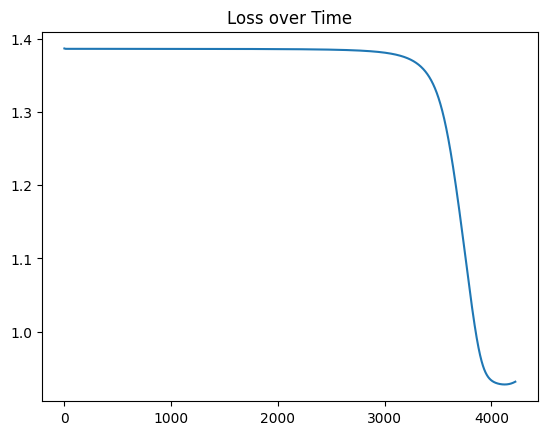

In [75]:
plt.plot(loss_func.losses)
plt.title('Loss over Time')
plt.show()

# Blackbox testing

Using the same parameters as our implementation, we test the neural network using the same dataset with the blackbox implementation. Both uses ReLU activation function for hidden lyaer, Softmax as activation output layer, and the same number of neurons in the hidden layer. The epochs and learning rate are also the same, and both uses stochastic gradient descent as the optimizer and have adaptive learning rate. The only differences is that the blackbox implementation does not provide flexibility on the activation function for each layer, so we have to use ReLu for both layers.

In [69]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

clf = MLPClassifier(hidden_layer_sizes=(128, 256, 128), max_iter=10000, 
                    activation='relu', solver='sgd', 
                    learning_rate_init=0.01, momentum=0.9, 
                    learning_rate='adaptive'
                    )
clf.fit(X_train, y_train)
clf.out_activation_

'softmax'

In [74]:
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.9225


We can see that the blackbox implementation outperforms our implementation in terms of accuracy. The blackbox implementation has an accuracy of 0.9225, while our implementation has an accuracy of 0.8231.

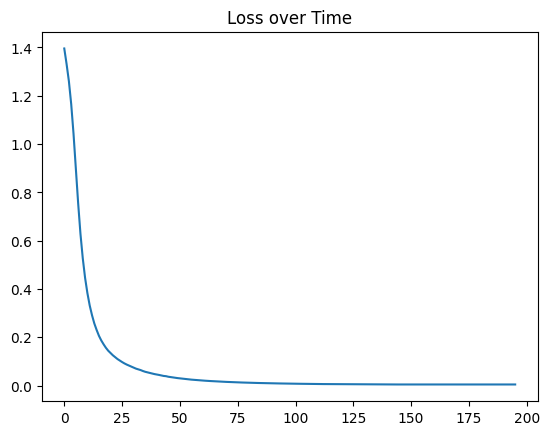

196


In [77]:
# look at the loss of clf
plt.plot(clf.loss_curve_)
plt.title('Loss over Time')
plt.show()

# print number of epochs
print(clf.n_iter_)

The blackbox implementation converges faster than our implementation. The blackbox implementation converges at 196 epochs, while our implementation converges at around 4000 epochs. The blackbox implementation employs a lot of optimization techniques such as regularization, batch normalization, and dropout, which our implementation does not have.